<a href="https://colab.research.google.com/github/taiharry108/captcha_recognition/blob/master/Captcha_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Captcha Recognition via fastai

---

fastai is a high level library built on top of PyTorch which simplifies training fast and accurate neural nets using modern best practices. It gives state-of-the-art result with minimal configurations because of its "out-of-the-box" support for different types of models. This is why I chose to use it for this project.

---
P.S. This notebook assumes you already run the following command to generate captcha by the [captcha library](https://pypi.org/project/captcha/).

```bash
$ python captcha_generation.py
```




## ---- 1 Defining the problem ----
A lot of websites implemented captcha verification to avoid automatic bots spamming their sites. It does that by asking users to enter some information that is supposed to be easy for human, but hard to write algorithms to solve. The most common type of captcha, before Google's reCAPTCHA, is to enter characters of a generated image. In the past, one would need to preprocess the images to make it easier to predict. With the evoluionary Convolutional Neural Network, it is now possible to simply solve them without much image processing.

### In this project, captcha images generated by the [captcha library](https://pypi.org/project/captcha/), which consists of 4 characters, is solved using the state-of-the-art deep learning model. Visualization of convolution filters is also provided to get better understanding of the model.

In [0]:
# Import all necessary functions and library according to the fastai paradigm
from fastai.vision import *
from fastai.callbacks.hooks import *

## ---- 2 Preprocessing ----
### Data Encoding




*   The model takes the input of an image in the form of numpy array and gives 4 predictions as the output.
*   For each prediction, there are 36 possible choices(0-9 and A-Z), so, the output layer consists of 144 nodes.
*   The character of the labels is encoded using the format: {CHARACTER}{POSITION}. For example, if the captcha is ABCD, it is labeled as "A0", "B1", "C2", "D3"
*   Since 4 characters have to be predict each time, it can be defined as a multilabel problem, with the exception that we know each time there are exactly 4 things to predict.

In [2]:
# Get all the inputs and targets from image files and save it to labels

def process_filename(filename):
    text = filename.split('_')[0]
    return list(map(lambda x: f'{x[1]}{x[0]}', enumerate(text)))

path = Path('captcha_img')
rows = []
for filename in os.listdir(path/'train'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('train', filename), process_filename(filename), False))

for filename in os.listdir(path/'valid'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('valid', filename), process_filename(filename), True))
    
df = pd.DataFrame(rows, columns=['name', 'label', 'is_valid'])

df.head()

,name,label,is_valid
0,train/G5F1_0.png,"[G0, 51, F2, 13]",False
1,train/4YG7_0.png,"[40, Y1, G2, 73]",False
2,train/DBX5_0.png,"[D0, B1, X2, 53]",False
3,train/O3L4_0.png,"[O0, 31, L2, 43]",False
4,train/X65Z_0.png,"[X0, 61, 52, Z3]",False


In [0]:
# Create a databunch object for the fastai learner
path = Path('captcha_img')
il = ImageList.from_df(df, path).split_from_df().label_from_df()
data = il.databunch()

Let's see how it the input data and the labels look

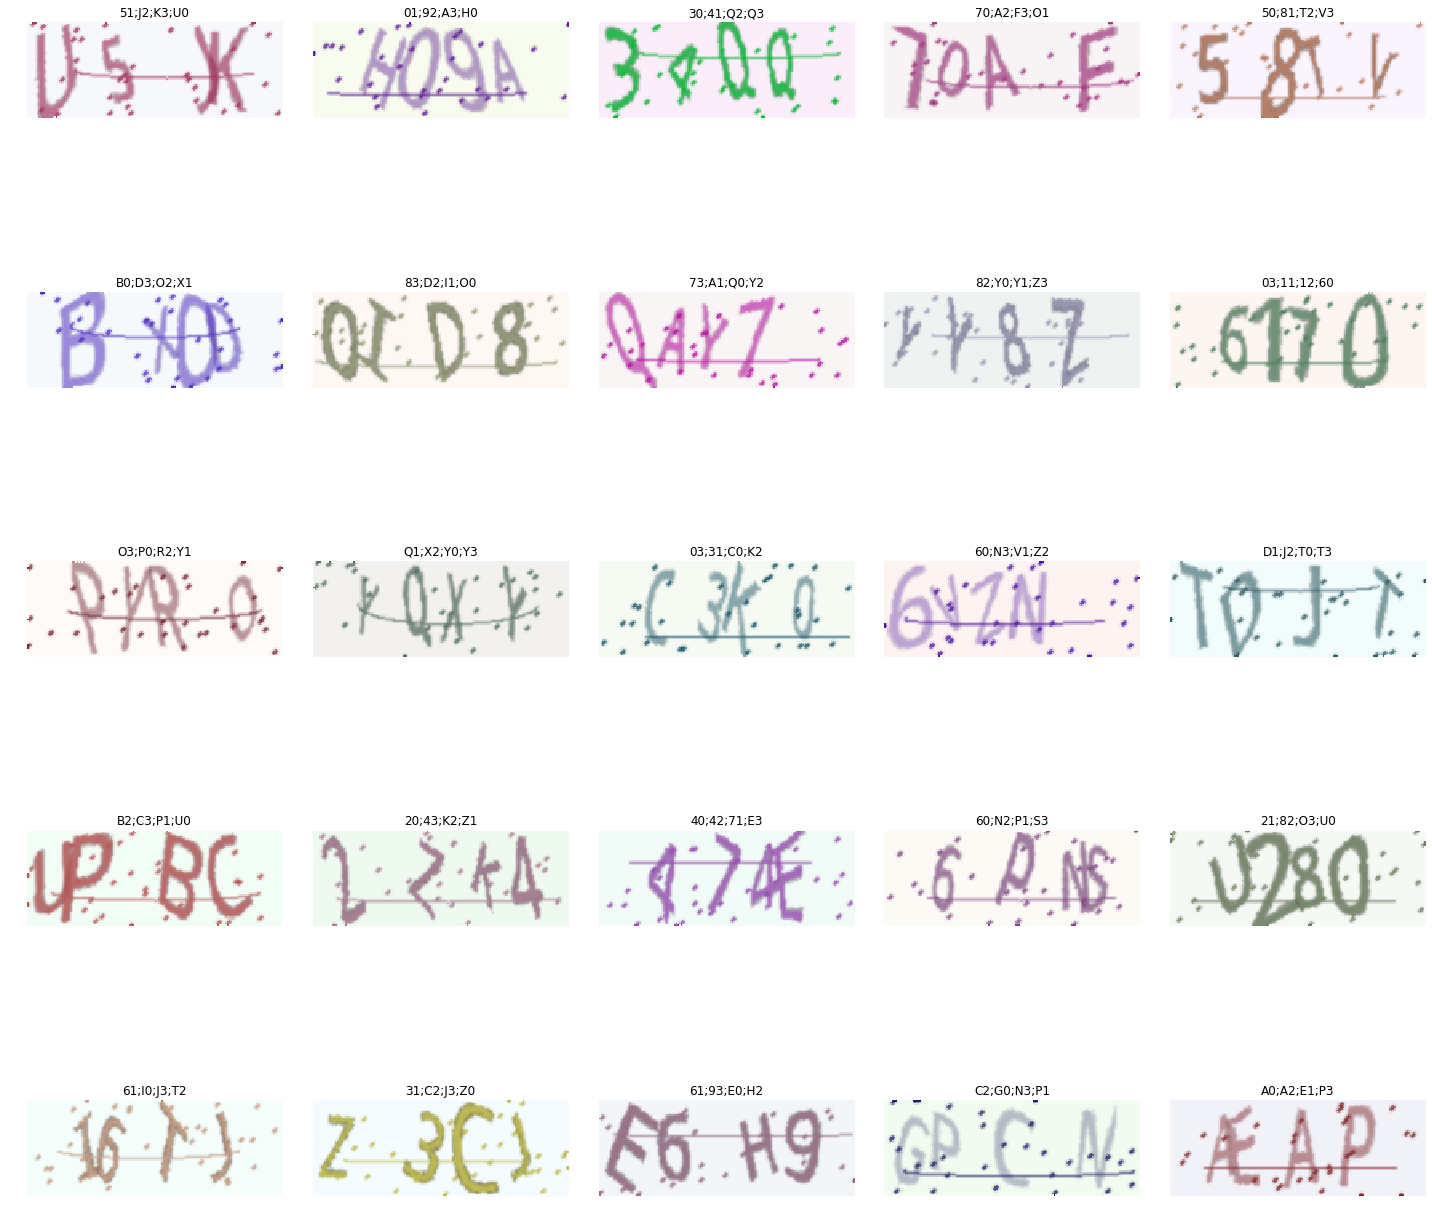

In [4]:
data.show_batch()

Before defining our learner, which is an object that encapsulates data and model at the same time in fastai, we need to define our metric because this is a special multilabel problem. The captcha accuracy is defined as the percentage of the characters being at the correct positions. For example, if the captcha is "ABCD" and it predicts "ABCB", the accuracy is 75%


In [0]:
def captcha_accuracy(y_pred, y_true, get_mean=True):
    sorted_pred, _ = y_pred.sort(1)
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    y_true = y_true.byte()
    
    result = (((y_pred == y_true) & (y_true == 1)).float().sum(1) / 4.)
    if get_mean == True:
        result = result.mean()
    return result


## ---- 3 Training ----

Define a cnn learner with the databunch and the metric we defined above. The resnet50 model is used as resnet gives a sufficiently good result in a reasonable amount of time, and, it should have enough compacity for the problem. Also, we use the default hyper-parameter as a baseline model.

In [0]:
learn = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False)

This is a learning rate finder provided by fastai to look for a suitable range of learning rates. It seems that the range 3e-3 to 2e-2 is where the loss drops rapidly.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


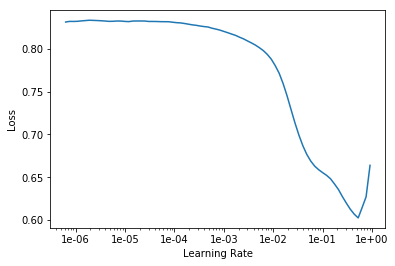

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [8]:
learn.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.022461,0.034255,0.577400,04:03
1,0.004978,0.003182,0.879800,04:01


In [0]:
learn.save('res50-default')

In [0]:
def get_preds_with_top_loss_idx(learn):
    y_pred, y_true, losses = learn.get_preds(with_loss=True)
    acc = captcha_accuracy(y_pred, y_true, get_mean=False)
    sorted_pred, _ = y_pred.sort(1)
    losses = losses.view((-1, 144)).mean(1)    
    top_loss_idx = losses.argsort(descending=True)
    
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    return y_pred, y_true, losses, top_loss_idx, acc

def show_top_losses(learn, row=3):
    y_pred, y_true, losses, top_loss_idx, acc = get_preds_with_top_loss_idx(learn)
    axs = subplots(row, row, figsize=(20, 10), title='index / pred / true / loss / accuracy').reshape(-1)
    y_recon = data.valid_ds.y.reconstruct
    for idx, ax in zip(top_loss_idx[:row*row], axs):
        title = f"{idx} / {y_recon(y_pred[idx])} / {y_recon(y_true[idx])} / {losses[idx]:0.3f} / {acc[idx]:0.2f}"
        ax = show_image(data.valid_ds[idx][0], ax=ax)
        ax.set_title(title)

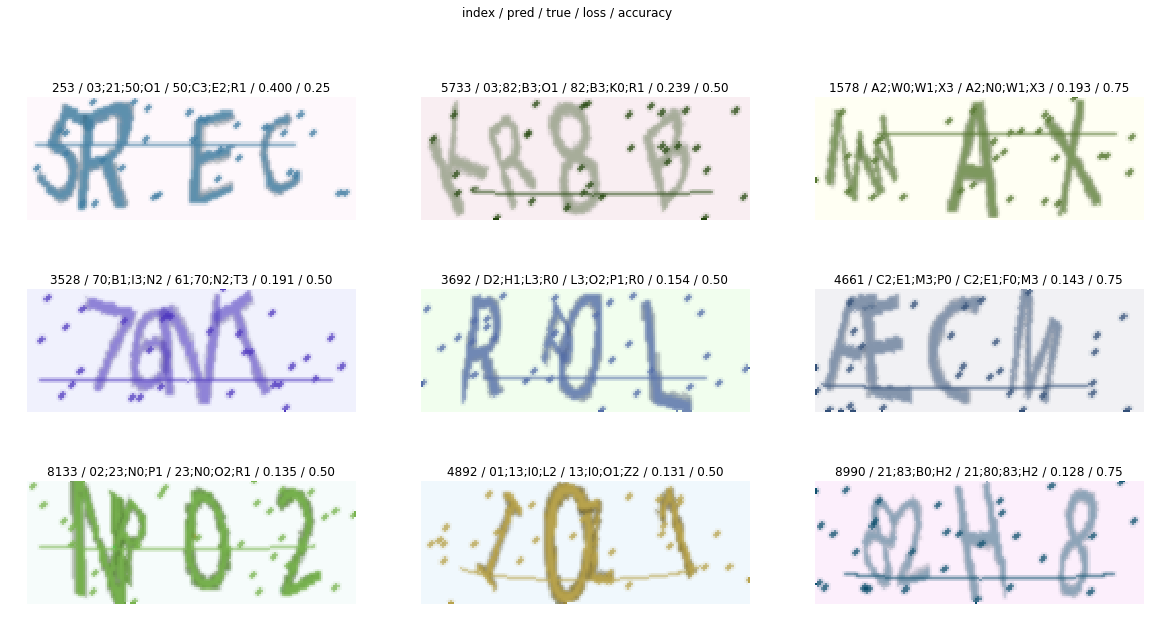

In [92]:
show_top_losses(learn)

From index 3692, 8133 and 4892, it seems that it has a hard time differentiating between 0's and O's. This makes sense because it is also hard to human.

## ---- 4 Model Tuning ----

After two epochs of training, it seems that the training loss is larger than the validation loss, which indicates the model is underfitted. Let's try to reduce the regularization effect by tuning down the weight decay and probabiliy of dropout.

In [0]:
learn2 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.05, ps=0.2)

In [94]:
learn2.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.014594,0.024399,0.881250,04:02
1,0.002782,0.002430,0.981025,04:01


In [0]:
learn2.save('res50-0.05-0.2')

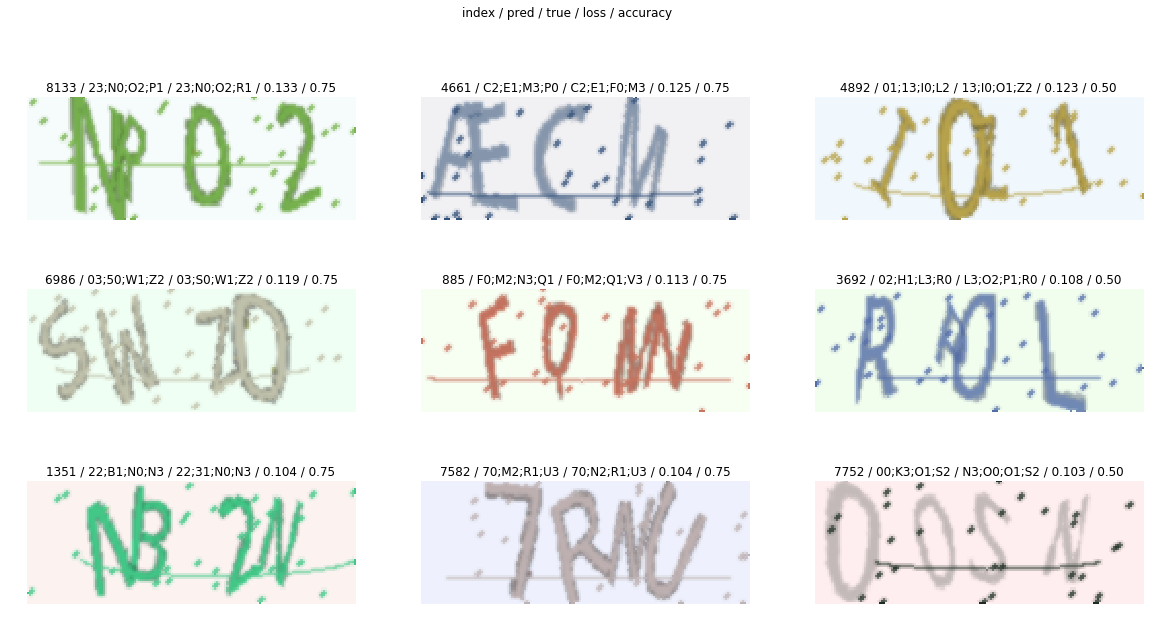

In [96]:
show_top_losses(learn2)

There seems to be some improvement! Let's try to tweak these two hyper-parameters a little more and see if we can boost the result.

In [97]:
learn3 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.02, ps=0.2)
learn3.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.014139,0.032401,0.859750,04:02
1,0.002684,0.002958,0.980175,04:01


In [0]:
learn3.save('res50-0.02-0.2')

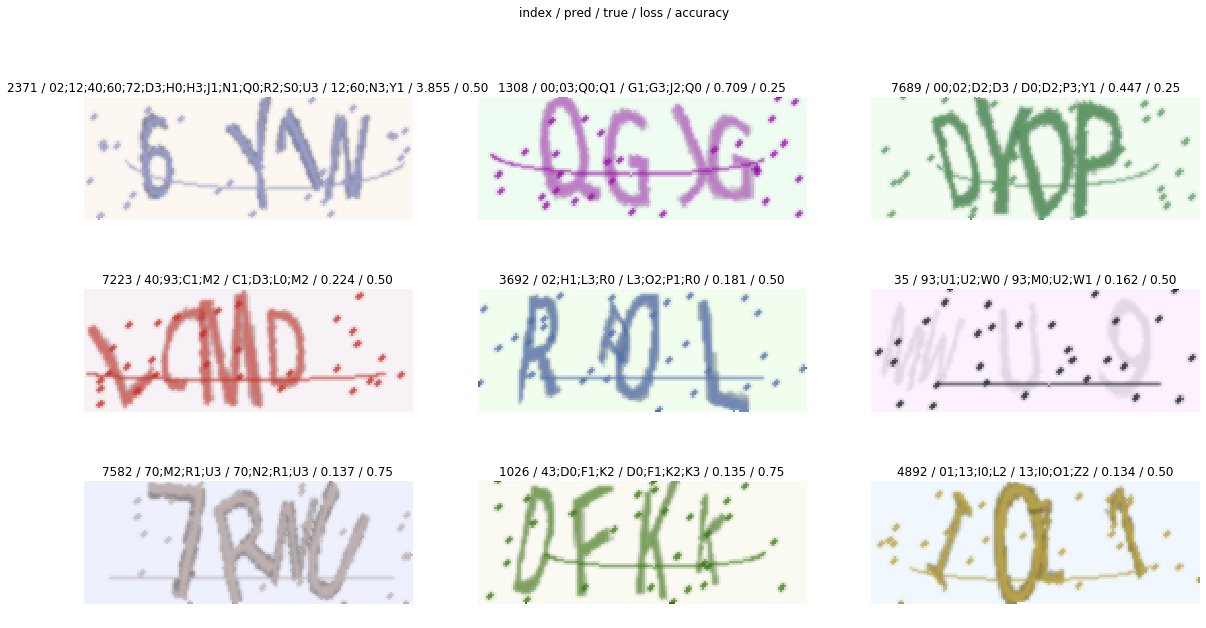

In [99]:
show_top_losses(learn3)

In [100]:
learn4 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.2)
learn4.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.012772,0.167218,0.435825,04:03
1,0.002984,0.002910,0.973200,04:02


In [0]:
learn4.save('res50-0.01-0.2')

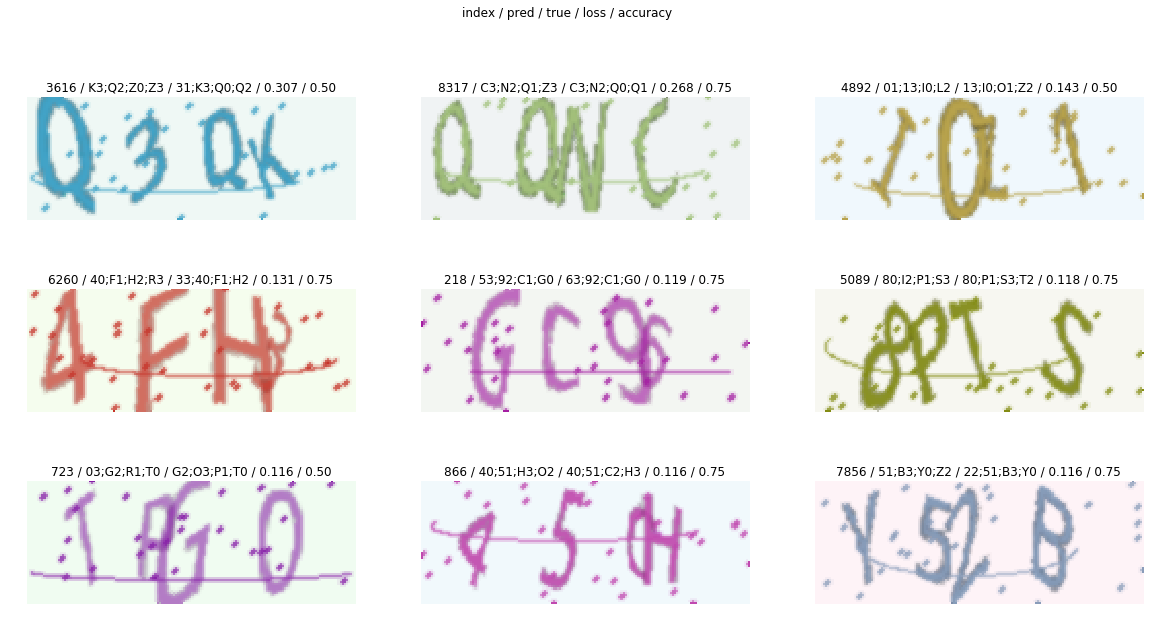

In [102]:
show_top_losses(learn4)

In [103]:
learn5 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.1)
learn5.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.010801,0.037509,0.830575,04:01
1,0.002611,0.002532,0.981475,04:01


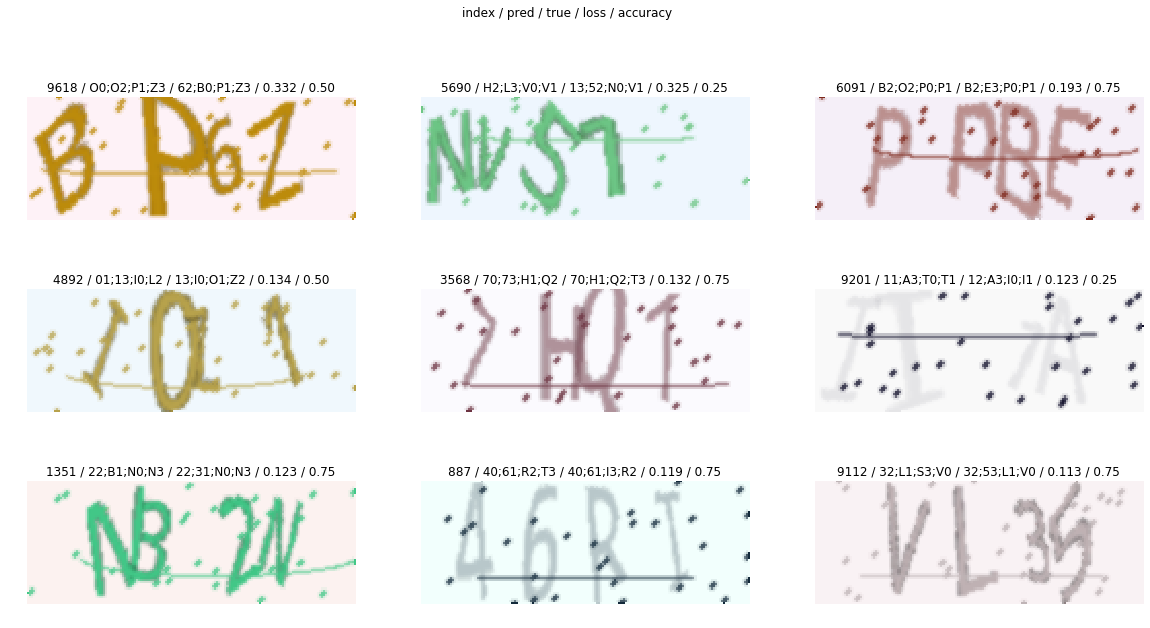

In [104]:
show_top_losses(learn5)

In [0]:
learn5.save('res50-0.01-0.1')

## ---- 5 Model Opitimization ----

It seems that learner 2 gives a pretty good result. The largest loss in the validation set is 0.133. Let's try to see if it can be further optimized.

Use the learning rate finder again to find a better range of learning rates now.

In [106]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


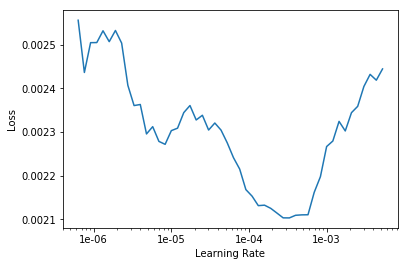

In [108]:
learn2.recorder.plot(skip_end=10)

In [109]:
learn2.fit_one_cycle(1, max_lr=slice(1e-6,5e-5))

epoch,train_loss,valid_loss,captcha_accuracy,time
0,0.002336,0.002397,0.981900,04:01


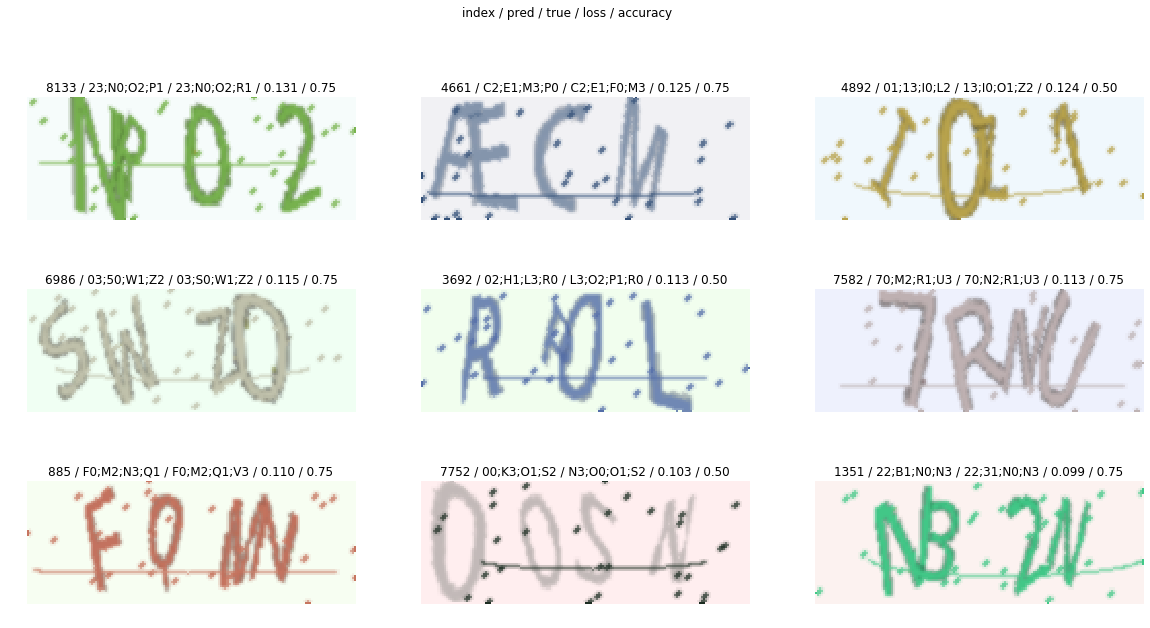

In [110]:
show_top_losses(learn2)

The model still has a hard time differentiating between 0's and O's. Other misclassification problems are mainly caused by the connected characters.

In [0]:
learn2.save('res50-0.05-0.2-stage2')

In [0]:
learn2 = learn2.load('res50-0.05-0.2-stage2')

## ---- 6 Visualization ---

It is also useful to visualize the convolutional layers to learn more about the network. The following visualization is done by visualizing the activation of a certain layer and overlaying it on top of the images. This tells you which part of the image the layer is "looking" at.

In [0]:
def hooked_backward(learn, xb, layer_idx):
    m = learn.model.eval()
    with hook_output(m[0][layer_idx]) as hook_a:
            preds = m(xb)
    return hook_a,hook_g


def show_heatmap(hm, x_im, item_idx, layer_idx, ax):
    x_im.show(ax, title=f'layer {layer_idx}, item {item_idx}')
    ax.imshow(hm, alpha=0.6, extent=(0,160, 60,0),
              interpolation='bilinear', cmap='magma');

def visualize_layer_of_item(learn, item_idxes, layer_idxes, row=2):
    data = learn.data
    axes = subplots(row, row, figsize=(20, 10)).reshape(-1)
    for item_idx, layer_idx, ax in zip(item_idxes, layer_idxes, axes):
        x,y = data.valid_ds[item_idx]
        xb, _ = data.one_item(x)

        hook_a,hook_g = hooked_backward(learn, xb.cuda(), layer_idx)
        acts  = hook_a.stored[0].cpu()
        avg_acts = acts.mean(0)

        show_heatmap(avg_acts, x, item_idx, layer_idx, ax)

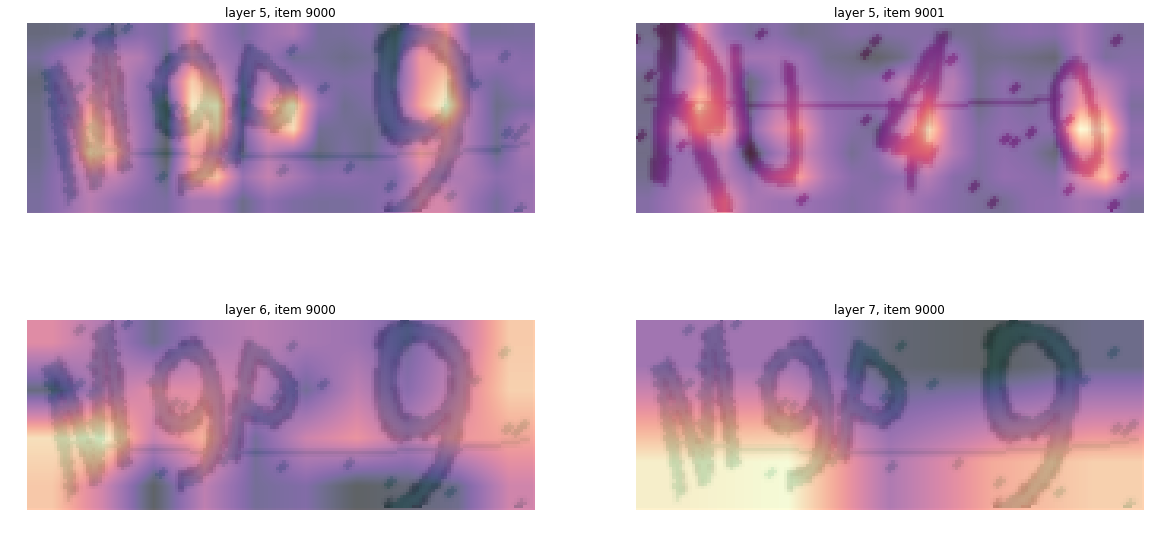

In [162]:
visualize_layer_of_item(learn2, [9000, 9001, 9000, 9000], [5, 5, 6, 7])

You can see that the earlier layers focus on the detailed of the characters while the later layers focus on the overall picture of the images.

## ---- 7 Conclusion ----

Modern deep learning method is really great at image recognition. With the help of the fastai library, a sufficiently good result can be obtained by using the default parameters. Tuning the hyper-parameters can give you state-of-the-art results. Some suggestions on how to improve the existing solution.

1.   Solve captcha of variable length. This may be done by assuming a maximum number of characters a captcha can contain.
2.   Instead of treating it as a multilabel problem, where the output nodes are applied by a sigmoid function, it is possible to treat it as a network which predicts 4 multiclass outputs. Technically, the output layer size is still (10 + 26) * 4, however, a softmax function is applied 4 times to each of the (10 + 26) nodes to make sure we can always pick one character for each position. (Unlike the case happened for learner 3)
3.   Since it is hard to distinguish between O's and 0's, in production, it may be better to request for a new captcha when either one of them is predicted.